# Load and Process data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import compute_hs, set_seed
from nn import prepare_y

In [4]:
set_seed(42)

In [10]:
from utils import data_processing

folder_path = 'buoy_data'
dfs_interpolated = data_processing(folder_path, save_path='buoy_data/processed_data.pkl')
density, alpha_1, alpha_2, r_1 = dfs_interpolated

All DataFrames have matching, continuous hourly datetime indexes.
Preprocessed data saved to buoy_data/processed_data.pkl


/home/g1/henriqueb/Projects/wave_forecast/utils/check_time.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_range = pd.date_range(start=ref_index.min(), end=ref_index.max(), freq='H')


In [11]:
print(density)

                     .0200  .0325  .0375  .0425  .0475  .0525  .0575  .0625  \
2016-01-01 00:00:00    0.0    0.0    0.0    0.0    0.0   0.01   0.21   0.65   
2016-01-01 01:00:00    0.0    0.0    0.0    0.0    0.0   0.00   0.17   0.57   
2016-01-01 02:00:00    0.0    0.0    0.0    0.0    0.0   0.00   0.00   0.31   
2016-01-01 03:00:00    0.0    0.0    0.0    0.0    0.0   0.00   0.15   0.77   
2016-01-01 04:00:00    0.0    0.0    0.0    0.0    0.0   0.05   0.14   0.78   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-31 19:00:00    0.0    0.0    0.0    0.0    0.0   0.02   0.72   1.49   
2017-12-31 20:00:00    0.0    0.0    0.0    0.0    0.0   0.00   0.26   0.91   
2017-12-31 21:00:00    0.0    0.0    0.0    0.0    0.0   0.11   0.98   2.33   
2017-12-31 22:00:00    0.0    0.0    0.0    0.0    0.0   0.20   0.59   2.13   
2017-12-31 23:00:00    0.0    0.0    0.0    0.0    0.0   0.00   0.81   2.23   

                     .0675  .0725  ...  .3300  .340

# Visualize data

In [88]:
month = 24*30

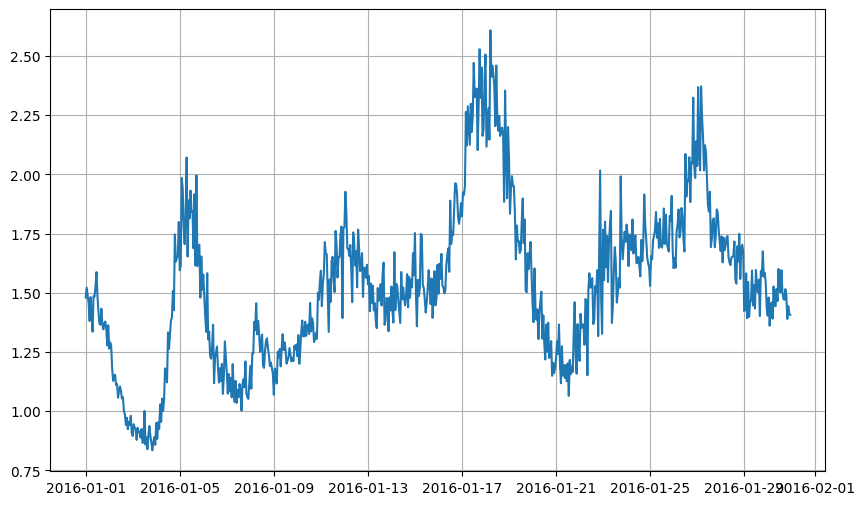

In [89]:
freqs = np.array([float(f) for f in density.columns])
hs = compute_hs(density, freqs)
plt.figure(figsize=(10, 6))
plt.plot(density.index[0:month], hs[0:month])
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Hs Power Spectral Density')

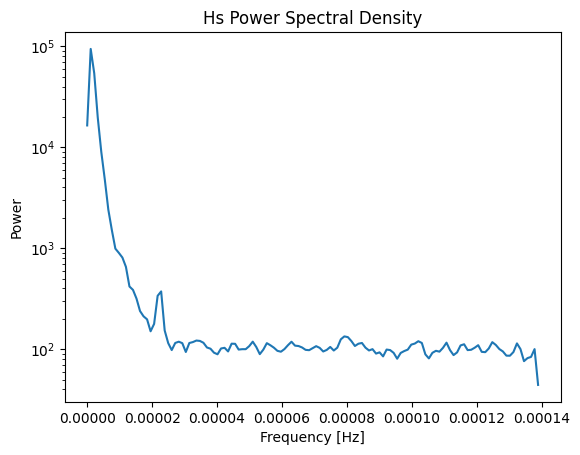

In [ ]:
from scipy.signal import welch

f, Pxx = welch(hs, fs=1/3600)
plt.semilogy(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Hs Power Spectral Density')

d:\Documentos\Projects\wave_forecast\venv\lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Documentos\Projects\wave_forecast\venv\lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


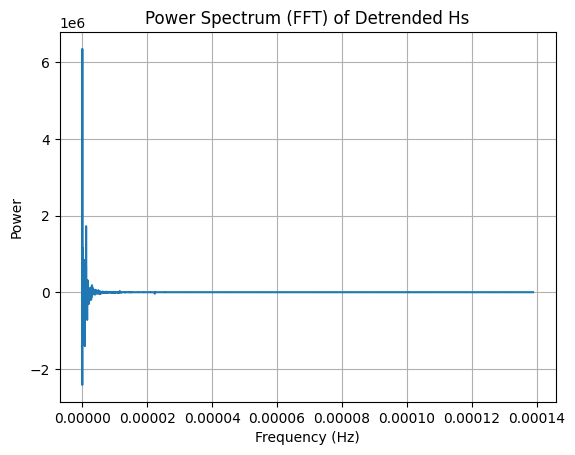

In [45]:
from scipy.fft import fft, fftfreq
from scipy.signal import detrend

freqs = np.array([float(f) for f in density.columns])

hs = compute_hs(density, freqs)

hs_detrended = detrend(hs, type='constant')
N = len(hs_detrended)
f_s = 1/3600

W = fft(hs_detrended)
freqs = fftfreq(N, 1/f_s)

mask = freqs >= 0
freqs = freqs[mask]
power = (W[mask])**2

plt.plot(freqs, power)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum (FFT) of Detrended Hs")
plt.grid()
plt.show()

In [78]:
np.sqrt(0.0259)

np.float64(0.1609347693943108)

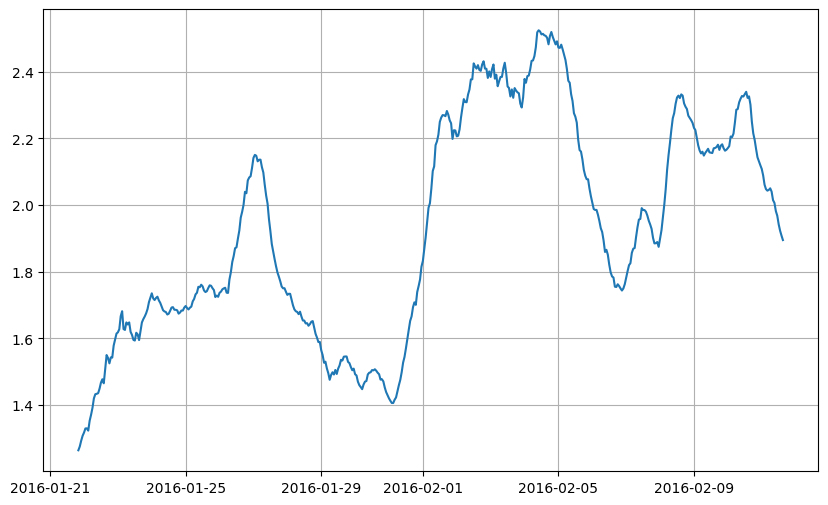

In [28]:
hs = compute_hs(density, freqs)
window_size = int(12)
raw_series = pd.Series(hs)
time_series = raw_series.rolling(window=window_size, center=True).mean()
hs = time_series.to_numpy()

plt.figure(figsize=(10, 6))
plt.plot(density.index[500:1000], hs[500:1000])
plt.grid(True)
plt.show()

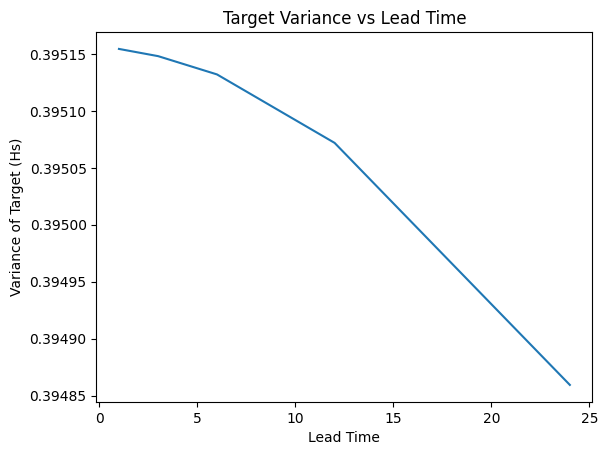

In [ ]:
variances = []
for lt in [1, 3, 6, 12, 24]:
    y = prepare_y(density, seq_length=24, lead_time=lt, target='hs')
    var = y.numpy().var()
    variances.append(var)

plt.plot([1, 3, 6, 12, 24], variances)
plt.xlabel('Lead Time')
plt.ylabel('Variance of Target (Hs)')
plt.title('Target Variance vs Lead Time')
plt.show()


In [21]:
import matplotlib.pyplot as plt

def plot_wave_spectrum(df, sample_index=0, variable_name="Spectral Density"):
    """
    Plot the wave spectrum (spectral density vs frequency) for one sample row.
    
    Parameters:
        df (pd.DataFrame): DataFrame with frequency columns.
        sample_index (int): Positional index of the row to plot.
        variable_name (str): Name of the variable for titles and labels.
    """
    # Extract original column names that can be converted to float (frequency columns)
    freq_cols = []
    for col in df.columns:
        try:
            float(col)
            freq_cols.append(col)
        except ValueError:
            pass

    freq_cols_sorted = sorted(freq_cols, key=lambda x: float(x))
    spectrum = df.iloc[sample_index][freq_cols_sorted].values
    freqs = [float(f) for f in freq_cols_sorted]

    plt.figure(figsize=(10, 6))
    plt.plot(freqs, spectrum, marker='o', label=variable_name)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(variable_name)
    plt.title(f'Wave Spectrum for (Sample Index {sample_index})')
    plt.legend()
    plt.grid(True)
    plt.show()


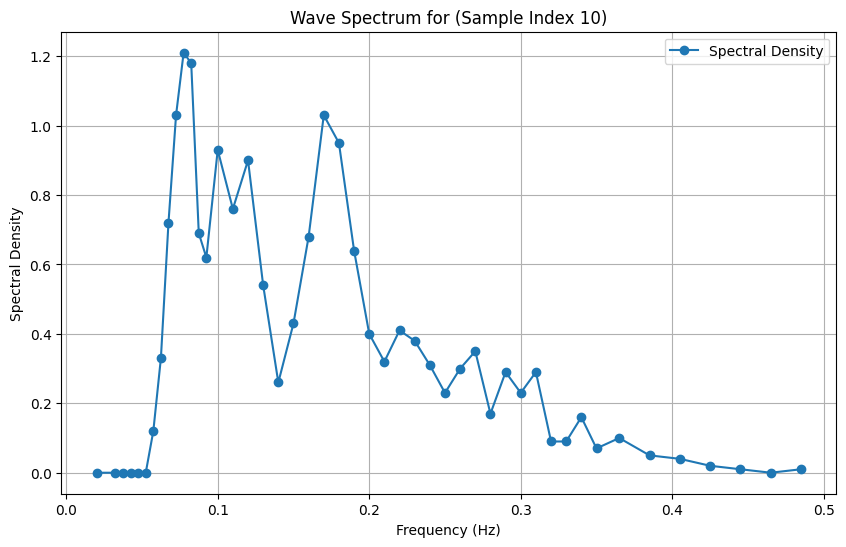

In [ ]:
plot_wave_spectrum(density, sample_index=10, variable_name="Spectral Density")

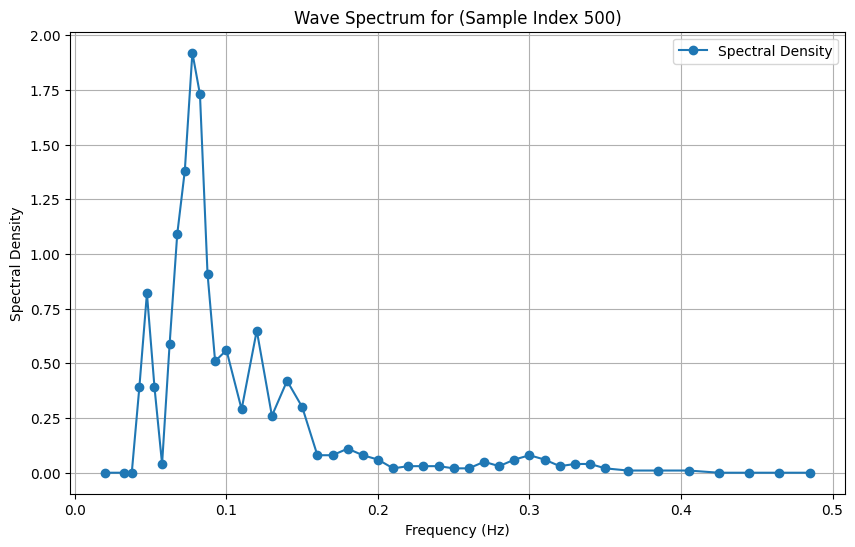

In [ ]:
plot_wave_spectrum(density, sample_index=500, variable_name="Spectral Density")

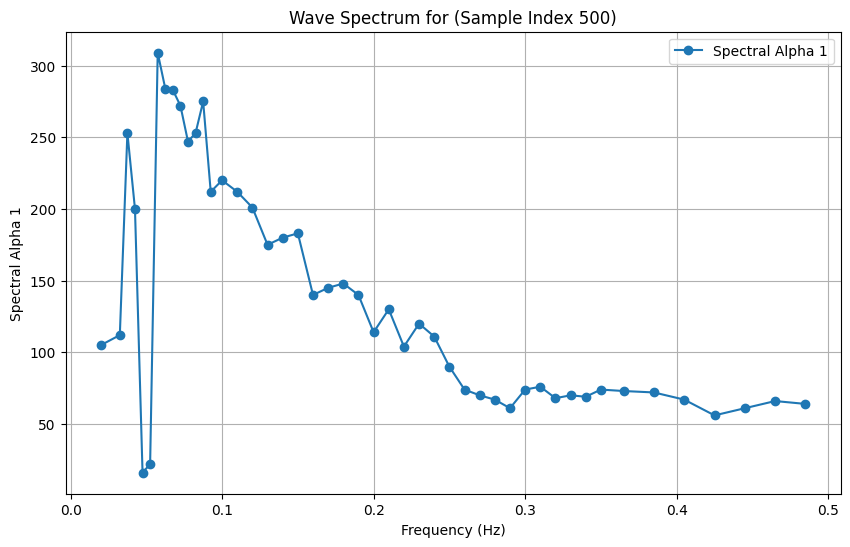

In [25]:
plot_wave_spectrum(alpha_1, sample_index=500, variable_name="Spectral Alpha 1")

# Pytorch

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
from nn import prepare_X, prepare_y, WaveSpectralDataset, WaveHeightBaselineNN, train_one_epoch, evaluate
from utils import get_freqs
from torch.utils.data import DataLoader
import torch.optim as optim

In [6]:
target = 'density'
seq_length = 24
lead_time = 6
batch_size = 32
lr = 1e-3
num_epochs = 15

# Naive Predictor

Predictor 1

In [80]:
num_timesteps, num_freqs = density.shape
num_samples = num_timesteps - seq_length - lead_time + 1
y = prepare_y(density, seq_length=seq_length, lead_time=lead_time, target='hs')

naive_preds = []
for i in range(num_samples):
    naive = hs[i + seq_length - 1]  # Last observed hs
    naive_preds.append([naive] * lead_time)  # Repeat for full lead time

naive_preds = np.array(naive_preds).reshape(num_samples, lead_time, 1)
mse_naive = ((naive_preds - y.numpy())**2).mean()
mse_naive

np.float64(0.041819833515080514)

Predictor 2

In [81]:
hs_mean = hs.mean()

# Create naive predictions: always predict the mean
naive_preds_mean = np.full((num_samples, lead_time, 1), hs_mean, dtype=np.float32)

# Compute MSE
mse_naive_mean = ((naive_preds_mean - y.numpy())**2).mean()
mse_naive_mean

np.float32(0.3951335)

Predictor 1.2

In [82]:
# Convert to NumPy *only for naive predictor*
density_np = density.values.astype(np.float32)

num_timesteps, num_freqs = density_np.shape
num_samples = num_timesteps - seq_length - lead_time + 1

# Naive predictor: last spectrum repeated across lead_time
naive_preds = []
for i in range(num_samples):
    last_spectrum = density_np[i + seq_length - 1]  # Last observed spectrum
    naive_preds.append(np.tile(last_spectrum, (lead_time, 1)))  # shape: (lead_time, num_freqs)

naive_preds = np.array(naive_preds)  # shape: (num_samples, lead_time, num_freqs)

# Get true values using original DataFrame
y = prepare_y(density, seq_length=seq_length, lead_time=lead_time, target='density')  # don't convert to NumPy here

# Compute MSE
mse_naive_last_spectrum = ((naive_preds - y.numpy()) ** 2).mean()
print(f"Naive MSE (last spectrum): {mse_naive_last_spectrum:.6f} m⁴/Hz²")

Naive MSE (last spectrum): 1.487994 m⁴/Hz²


Predictor 2.2

In [83]:
# Convert DataFrame to numpy array
density_array = density.values.astype(np.float32)  # shape: (time, num_freqs)
num_timesteps, num_freqs = density_array.shape

# Step 1: Compute the mean spectrum across time (shape: [num_freqs])
mean_spectrum = density_array.mean(axis=0)  # shape: (num_freqs,)

# Step 2: Determine number of samples (same logic as prepare_y)
num_samples = num_timesteps - seq_length - lead_time + 1

# Step 3: Create naive predictions of shape (num_samples, lead_time, num_freqs)
naive_preds_mean = np.tile(mean_spectrum, (num_samples, lead_time, 1)).astype(np.float32)

# Step 4: Get ground truth target
y = prepare_y(density, seq_length=seq_length, lead_time=lead_time, target='density')  # shape: (samples, lead_time, num_freqs)

# Step 5: Compute MSE between naive and ground truth
mse_naive_mean = ((naive_preds_mean - y.numpy())**2).mean()

print(f"MSE of naive mean-spectrum predictor: {mse_naive_mean:.6f} (units: m⁴/Hz²)")

MSE of naive mean-spectrum predictor: 4.193316 (units: m⁴/Hz²)


In [ ]:
X = prepare_X(density, alpha_1, alpha_2, r_1, seq_length=seq_length, lead_time=lead_time)
y = prepare_y(density, seq_length=seq_length, lead_time=lead_time, target=target)
print(X.shape)
print(y.shape)

total_samples = len(X)
train_size = int(0.8 * total_samples) # 80/20 split

train_X = X[:train_size]
val_X   = X[train_size:]

train_y = y[:train_size]
val_y   = y[train_size:]

train_dataset = WaveSpectralDataset(train_X, train_y)
val_dataset   = WaveSpectralDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.Size([17515, 24, 47, 4])
torch.Size([17515, 6, 47])


seq_len (24, 48, 72, ...? ): the number of time steps the model takes as input for training

lead_time (6, 12, 24, 48, 72): the number of time steps ahead the model should predict

batch_size (32, 64, 128): the number of samples processed in parallel

learning rate (lr) (1e-3, ...?): 

# Evaluate Density

Train model on train+val set

In [36]:
best_params = {'seq_len': 12, 'batch_size': 32, 'lr': 0.0004754660087671511, 'dropout': 0.24914473236486379	, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'embed_dim': 64, 'weight_decay': 0.000011428753986933172}
freqs = get_freqs(density)
lead_time = 6
seq_length = best_params['seq_len']
target = 'density'
num_epochs = 15
density = density[::6]

len_density = len(density)
train_size = int(0.8 * len_density)
train_density = density.iloc[:train_size]
test_density = density.iloc[train_size:]

X = prepare_X(train_density, alpha_1, alpha_2, r_1, seq_length, lead_time)
y = prepare_y(train_density, seq_length, lead_time, target=target)

train_loader = DataLoader(WaveSpectralDataset(X, y), batch_size=best_params['batch_size'], shuffle=True)

# Rebuild model before training
d_model = WaveHeightBaselineNN(
    num_freqs=X.shape[2],
    freqs=freqs,
    target=target,
    nhead=best_params['nhead'],
    num_encoder_layers=best_params['num_encoder_layers'],
    num_decoder_layers=best_params['num_decoder_layers'],
    embed_dim=best_params['embed_dim'],
    dropout=best_params['dropout']
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d_model = d_model.to(device)

optimizer = optim.AdamW(d_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

# Train the model with best hyperparameters using full X and y
for epoch in range(num_epochs):
    train_loss = train_one_epoch(d_model, train_loader, optimizer, device=device, freqs=freqs)

# Save trained model
torch.save(d_model.state_dict(), 'best_model.pth')

Evaluate model on holdout set

In [10]:
# --- Plot 2: Hs evolution over lead time ---
def reshape_for_hs(tensor):
    # tensor: (lead_time, num_freqs)
    # returns: (lead_time, num_freqs) -> compatible with compute_hs
    return tensor.numpy()

In [20]:
lead_times = [1, 2, 3, 4, 5, 6]

# use the maximum lead time in preparation, then slice the predictions for smaller lead times.
X_test = prepare_X(test_density, alpha_1, alpha_2, r_1, seq_length=best_params['seq_len'], lead_time=max(lead_times))
y_test = prepare_y(test_density, seq_length=best_params['seq_len'], lead_time=max(lead_times), target='density')

test_dataset = WaveSpectralDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

mean_rmse, rmse_windows = rolling_window_error(d_model, test_loader, freqs, 'cpu', window=2, target='density')

NameError: name 'd_model' is not defined

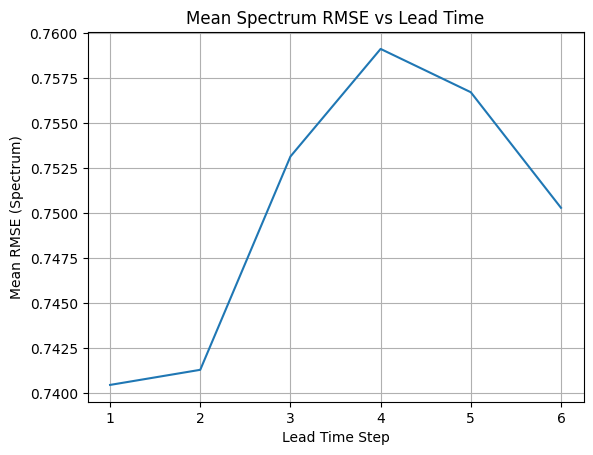

In [59]:
mean_rmse_curve = mean_rmse.mean(axis=1)
plt.plot(range(1, len(mean_rmse_curve)+1), mean_rmse_curve)
plt.xlabel("Lead Time Step")
plt.ylabel("Mean RMSE (Spectrum)")
plt.title("Mean Spectrum RMSE vs Lead Time")
plt.grid(True)
plt.show()

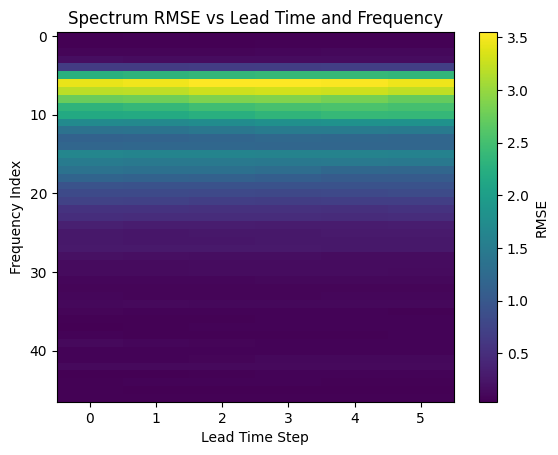

In [60]:
plt.imshow(mean_rmse.T, aspect='auto', cmap='viridis')
plt.colorbar(label="RMSE")
plt.xlabel("Lead Time Step")
plt.ylabel("Frequency Index")
plt.title("Spectrum RMSE vs Lead Time and Frequency")
plt.show()

# Evaluate Hs

In [5]:
best_params = {'seq_len': 48, 'batch_size': 32, 'lr': 0.0010739030584532173, 'dropout': 0.12451088872474807, 'nhead': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 1, 'embed_dim': 64, 'weight_decay': 3.468487658805434e-05}
freqs = get_freqs(density)
lead_time = 6
seq_length = best_params['seq_len']
target = 'hs'
num_epochs = 15

len_density = len(density)
train_size = int(0.8 * len_density)
train_density = density.iloc[:train_size]
test_density = density.iloc[train_size:]
train_alpha_1 = alpha_1.iloc[:train_size]
test_alpha_1 = alpha_1.iloc[train_size:]
train_alpha_2 = alpha_2.iloc[:train_size]
test_alpha_2 = alpha_2.iloc[train_size:]
train_r1 = r_1.iloc[:train_size]
test_r1 = r_1.iloc[train_size:]


X = prepare_X(train_density, train_alpha_1, train_alpha_2, train_r1, seq_length, lead_time)
y = prepare_y(train_density, seq_length, lead_time, target=target)

train_loader = DataLoader(WaveSpectralDataset(X, y), batch_size=best_params['batch_size'], shuffle=True)

# Rebuild model before training
hs_model = WaveHeightBaselineNN(
    num_freqs=X.shape[2],
    freqs=freqs,
    target=target,
    nhead=best_params['nhead'],
    num_encoder_layers=best_params['num_encoder_layers'],
    num_decoder_layers=best_params['num_decoder_layers'],
    embed_dim=best_params['embed_dim'],
    dropout=best_params['dropout']
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hs_model = hs_model.to(device)

optimizer = optim.AdamW(hs_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

# Train the model with best hyperparameters using full X and y
for epoch in range(num_epochs):
    train_loss = train_one_epoch(hs_model, train_loader, optimizer, device=device, freqs=freqs)

# Save trained model
torch.save(hs_model.state_dict(), 'best_model.pth')

In [21]:
lead_times = [1, 2, 3, 4, 5, 6]

# use the maximum lead time in preparation, then slice the predictions for smaller lead times.
X_test = prepare_X(test_density, test_alpha_1, test_alpha_2, test_r1, seq_length=best_params['seq_len'], lead_time=max(lead_times))
y_test = prepare_y(test_density, seq_length=best_params['seq_len'], lead_time=max(lead_times), target=target)

test_dataset = WaveSpectralDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

In [22]:
hs_mean_rmse, hs_rmse_windows = rolling_window_error(hs_model, test_loader, freqs, 'cpu', window=2, target='hs')

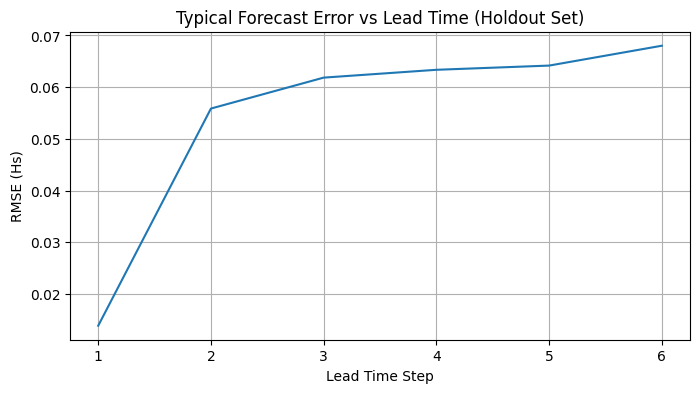

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(hs_mean_rmse)+1), hs_mean_rmse)
plt.xlabel("Lead Time Step")
plt.ylabel("RMSE (Hs)")
plt.title("Typical Forecast Error vs Lead Time (Holdout Set)")
plt.grid(True)
plt.show()

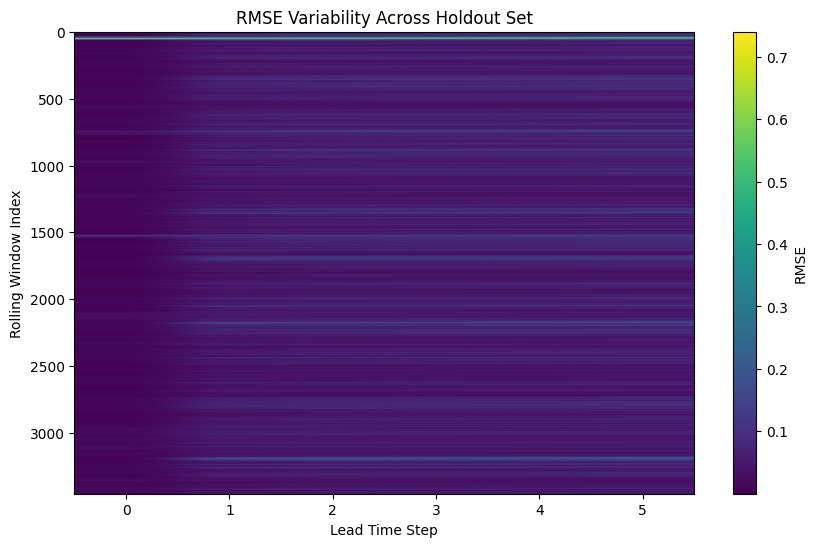

In [24]:
plt.figure(figsize=(10, 6))
plt.imshow(hs_rmse_windows, aspect='auto', cmap='viridis')
plt.colorbar(label="RMSE")
plt.xlabel("Lead Time Step")
plt.ylabel("Rolling Window Index")
plt.title("RMSE Variability Across Holdout Set")
plt.show()

In [ ]:
def plot_batch_predictions(model, val_loader, freqs, device, idx=0):
    """
    Plots a batch sample: spectrum and Hs evolution.

    Parameters:
    - model: trained model
    - val_loader: DataLoader yielding (src, tgt)
    - freqs: list or array of frequencies
    - device: 'cpu' or 'cuda'
    - idx: index within the batch to visualize
    """
    model.eval()
    batch = next(iter(val_loader))
    src, tgt = batch
    src = src.to(device)
    tgt = tgt.to(device)

    with torch.no_grad():
        pred = model(src, tgt)  # (batch_size, lead_time, num_freqs)

    # Move tensors to CPU
    src = src.cpu()
    tgt = tgt.cpu()
    pred = pred.cpu()

    # --- Plot 1: Spectrum at different lead times ---
    tgt_seq = tgt[idx].numpy()         # (lead_time, num_freqs)
    pred_seq = pred[idx].numpy()       # (lead_time, num_freqs)

    lead_time = tgt_seq.shape[0]
    times = [0, lead_time // 2, lead_time - 1]

    fig, axs = plt.subplots(1, len(times), figsize=(18, 4))
    for i, t in enumerate(times):
        axs[i].plot(freqs, tgt_seq[t], label='Target', lw=2)
        axs[i].plot(freqs, pred_seq[t], label='Predicted', lw=2, linestyle='--')
        axs[i].set_title(f"Spectral Density at t+{t}")
        axs[i].set_xlabel("Frequency (Hz)")
        axs[i].set_ylabel("Spectral Density")
        axs[i].legend()
        axs[i].grid(True)

    plt.suptitle("Spectral Prediction vs. Target")
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Hs evolution over lead time ---
    def reshape_for_hs(tensor):
        # tensor: (lead_time, num_freqs)
        # returns: (lead_time, num_freqs) -> compatible with compute_hs
        return tensor.numpy()

    # Ensure freqs is a 1D array
    freqs = np.array(freqs)

    # Reshape properly for compute_hs
    true_density = reshape_for_hs(tgt[idx])
    pred_density = reshape_for_hs(pred[idx])

    hs_true = compute_hs(true_density, freqs)  # (lead_time,)
    hs_pred = compute_hs(pred_density, freqs)

    plt.figure(figsize=(8, 4))
    plt.plot(hs_true, label='True Hs', marker='o')
    plt.plot(hs_pred, label='Predicted Hs', marker='x')
    plt.xlabel("Lead Time Step")
    plt.ylabel("Hs (m)")
    plt.title("Significant Wave Height Over Lead Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Evaluate on multiple lead_times (reloading same trained model)
for lead_time in lead_times:
    print(f"\nEvaluating lead_time = {lead_time}")

    X = prepare_X(test_density, test_alpha_1, test_alpha_2, test_r1, seq_length=best_params['seq_len'], lead_time=lead_time)
    y = prepare_y(test_density, seq_length=best_params['seq_len'], lead_time=lead_time, target=target)

    val_dataset = WaveSpectralDataset(X, y)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

    # Load trained model
    # Build model with exact same hyperparameters
    model = WaveHeightBaselineNN(
        num_freqs=X.shape[2],
        freqs=freqs,
        target=target,
        nhead=best_params['nhead'],
        num_encoder_layers=best_params['num_encoder_layers'],
        num_decoder_layers=best_params['num_decoder_layers'],
        embed_dim=best_params['embed_dim'],
        dropout=best_params['dropout']
    )
    model = model.to(device)
    # Load model weights
    model.load_state_dict(torch.load('best_model.pth'))

    val_loss = evaluate(model, val_loader, device=device, freqs=freqs)
    print(f"Val loss at lead_time {lead_time}: {val_loss['RMSE']:.4f}")
    plot_batch_predictions(model, val_loader, freqs=freqs, device=device, idx=0)


Evaluating lead_time = 1


100%|██████████| 109/109 [00:03<00:00, 32.98it/s]
C:\Users\Henrique\AppData\Local\Temp\ipykernel_2504\1099076437.py:35: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  freqs = np.array(freqs)


Val loss at lead_time 1: 0.1760


ValueError: operands could not be broadcast together with shapes (1,46) (1,0) 